In [1]:
import sys
!{sys.executable} -m pip uninstall smi-analysis --yes
!{sys.executable} -m pip install git+https://github.com/gfreychet/smi-analysis.git

Found existing installation: smi-analysis 0.1.0.post70+g87cab36
Uninstalling smi-analysis-0.1.0.post70+g87cab36:
  Successfully uninstalled smi-analysis-0.1.0.post70+g87cab36
  Cloning https://github.com/gfreychet/smi-analysis.git to c:\users\at280565\appdata\local\temp\pip-req-build-9e3s5xr4
  Resolved https://github.com/gfreychet/smi-analysis.git to commit 87cab36948499bc82bfef49101843bfc13014bb7
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for smi-analysis: started
  Running setup.py install for smi-analysis: finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/gfreychet/smi-analysis.git 'C:\Users\AT280565\AppData\Local\Temp\pip-req-build-9e3s5xr4'
  DEPRECATION: smi-analysis is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: C:\dev\sw\envs3\env_metrocarac\Scripts\python.exe -m pip install --upgrade pip


In [2]:
!{sys.executable} -m pip uninstall saxs-nxformat --yes
!{sys.executable} -m pip install git+https://github.com/CEA-MetroCarac/saxs_nxformat.git

Found existing installation: saxs_nxformat 2025.3
Uninstalling saxs_nxformat-2025.3:
  Successfully uninstalled saxs_nxformat-2025.3
  Cloning https://github.com/CEA-MetroCarac/saxs_nxformat.git to c:\users\at280565\appdata\local\temp\pip-req-build-gwd3_9b1
  Resolved https://github.com/CEA-MetroCarac/saxs_nxformat.git to commit 54fcd73c724bcb7339abcf38246cef20f339eec4
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for saxs_nxformat: filename=saxs_nxformat-2025.3-py3-none-any.whl size=6276358 sha256=7665dc7be8aed7138e77c6ea996259ecadd058ba0f008d7018607424675eadd9
  Stored in directory: C:\Users\AT280565\AppData\Local\Temp\pip-ephem-wheel-cache-l8peeq7h\wheels\9a\20\74\052151babf4924ba5f32632d

  Running command git clone --filter=blob:none --quiet https://github.com/CEA-MetroCarac/saxs_nxformat.git 'C:\Users\AT280565\AppData\Local\Temp\pip-req-build-gwd3_9b1'

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: C:\dev\sw\envs3\env_metrocarac\Scripts\python.exe -m pip install --upgrade pip


In [3]:
%matplotlib ipympl

import inspect
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import re

from pathlib import Path
from colorama import Fore, Style
from saxs_nxformat.class_nexus_file import NexusFile, save_data, extract_from_h5
from smi_analysis import SMI_beamline

# Glassy carbon treatment

In [4]:
def explore_file(group, explore_group=False, explore_dataset=False, level=0):
    indent = "|  " * level
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Group):
            print(f"{indent}{Fore.RED}Group : {key}{Style.RESET_ALL}")
            explore_file(item, explore_group, explore_dataset, level + 1)
        elif isinstance(item, h5py.Dataset) and explore_group:
            print(f"{indent}{Fore.CYAN}Dataset : {key}{Style.RESET_ALL}")
            if item.attrs and explore_dataset:
                print(f"{indent}  {Fore.GREEN}Attributes : {key}{Style.RESET_ALL}")
                for key_attribute, item_attribute in item.attrs.items():
                    print(f"{indent}    - {key_attribute} : {item_attribute}")

# Data extraction

In [5]:
data_dir = r"C:\Users\AT280565\Desktop\Data Treatment Center\Treated Data\instrument - XEUSS\year - 2025\config ID - 202503101406\experiment - measure\detector - SAXS\format - NX"
cali_dir = r"C:\Users\AT280565\Desktop\Data Treatment Center\Treated Data\instrument - XEUSS\year - 2025\config ID - 202503101406\experiment - measure\calibration - SAXS"

data_path_list = []
cali_path_list = []

print("Data list")
for file in os.listdir(data_dir):
    print(file)
    data_path_list.append(os.path.join(data_dir, file))
    
print("\nCalibration list")
for file in os.listdir(cali_dir):
    print(file)
    cali_path_list.append(os.path.join(cali_dir, file))

Data list
Glassy_Carbon_img00001_20250313155305.h5
Glassy_Carbon_img00004_20250313155226.h5
Glassy_Carbon_img00005_20250313155209.h5
Glassy_Carbon_img00008_20250313155130.h5

Calibration list
Glassy_Carbon_img00002_20250313155253.h5
Glassy_Carbon_img00003_20250313155242.h5
Glassy_Carbon_img00006_20250313155158.h5
Glassy_Carbon_img00007_20250313155147.h5


### Measure data


In [6]:
# For the data
nx_data_files = NexusFile(data_path_list, do_batch=False)
# We get the raw data
Q_data_dict_2D, I_data_dict_2D = nx_data_files.get_raw_data(group_name="DATA")

# We get the files
h5_file_obj = nx_data_files.get_file()

# We get the exposition time
expo_time_data = []
SDD_list = []
beam_center_list = []
for h5_file in h5_file_obj:
    beam_center_x = extract_from_h5(h5_file, "ENTRY/INSTRUMENT/DETECTOR/beam_center_x")
    beam_center_y = extract_from_h5(h5_file, "ENTRY/INSTRUMENT/DETECTOR/beam_center_y")
    beam_center_list.append([int(beam_center_x), int(beam_center_y)])
    
    time = extract_from_h5(h5_file, "ENTRY/COLLECTION/exposition_time")
    SDD = extract_from_h5(h5_file, "ENTRY/INSTRUMENT/DETECTOR/SDD")
    expo_time_data.append(time)
    SDD_list.append(SDD)

nx_data_files.nexus_close()

expo_time_data = np.array(expo_time_data)

### Calibration data

In [7]:
nx_cali_files = NexusFile(cali_path_list, do_batch=False)
# We get the raw data
Q_cali_dict_2D, I_cali_dict_2D = nx_cali_files.get_raw_data(group_name="DATA")

# We get the files
h5_file_obj = nx_cali_files.get_file()

# We get the beam centers and exposition times
expo_time_cali = []
for h5_file in h5_file_obj:
    time = extract_from_h5(h5_file, "ENTRY/COLLECTION/exposition_time")
    expo_time_cali.append(time)
    
nx_data_files.nexus_close()

expo_time_cali = np.array(expo_time_cali)

# Computing the sample's transmission for each SDD

### Time average of the sum of intensity in the ROI

In [8]:
list_I_ROI_data = []
list_I_ROI_cali = []
ROI_size = 25
for index, (name, data) in enumerate(I_data_dict_2D.items()):
    beam_center = beam_center_list[index]
    I_ROI = np.sum(
        data[
            beam_center[1]-ROI_size:beam_center[1]+ROI_size, 
            beam_center[0]-ROI_size:beam_center[0]+ROI_size
        ]
    )
    I_ROI = I_ROI / expo_time_data[index]
    list_I_ROI_data.append(I_ROI)

for index, (name, cali) in enumerate(I_cali_dict_2D.items()):
    beam_center = beam_center_list[index]
    I_ROI = np.sum(
        cali[
            beam_center[1]-ROI_size:beam_center[1]+ROI_size, 
            beam_center[0]-ROI_size:beam_center[0]+ROI_size
        ]
    )
    I_ROI = I_ROI / expo_time_cali[index]
    list_I_ROI_cali.append(I_ROI)
    
list_I_ROI_data = np.array(list_I_ROI_data)
list_I_ROI_cali = np.array(list_I_ROI_cali)

In [9]:
print("Time average intensity in the ROI for the sample      :", list_I_ROI_data)
print("Time average intensity in the ROI center for the cali :", list_I_ROI_cali)

Time average intensity in the ROI for the sample      : [5497912.96 5499548.16 5505669.12 5501530.88]
Time average intensity in the ROI center for the cali : [11453833.6 11501953.6 11496578.4 11528308.8]


### Transmission of the sample

In [10]:
transmission = (list_I_ROI_data) / (list_I_ROI_cali)
print("Sample transmission :", transmission)

Sample transmission : [0.48000636 0.47814035 0.47889632 0.47721925]


# Computing the scalling factor

In [11]:
factor_list = (list_I_ROI_data)/(list_I_ROI_cali*transmission*1.3e9)
print("Scaling factors :", factor_list)

Scaling factors : [7.69230769e-10 7.69230769e-10 7.69230769e-10 7.69230769e-10]


# Correcting the raw intensity

In [12]:
for index in range(0,len(cali_path_list)):
    cali_name = Path(cali_path_list[index]).name
    data_name = Path(data_path_list[index]).name
    
    I_data = (I_data_dict_2D[data_name])# - transmission[index]*(I_cali_dict_2D[cali_name])
    I_data = I_data * factor_list[index]
    
    with h5py.File(data_path_list[index], "r+") as h5obj:
        mask = np.logical_not(I_data >= 0)
        save_data(h5obj, "Q", Q_data_dict_2D[data_name], "DATA_ABS", I_data, mask)

# Doing the radial average using the Corrected data

In [13]:
nx_data_files = NexusFile(data_path_list, do_batch=True, input_data_group="DATA_ABS")
nx_data_files.process_radial_average(display=False, save=True, r_min=0.008, r_max=0.6, group_name="DATA_ABS_RAD_AVG")
dict_rad_avg_Q, dict_rad_avg_I = nx_data_files.get_raw_data(group_name="DATA_ABS_RAD_AVG")
nx_data_files.nexus_close()

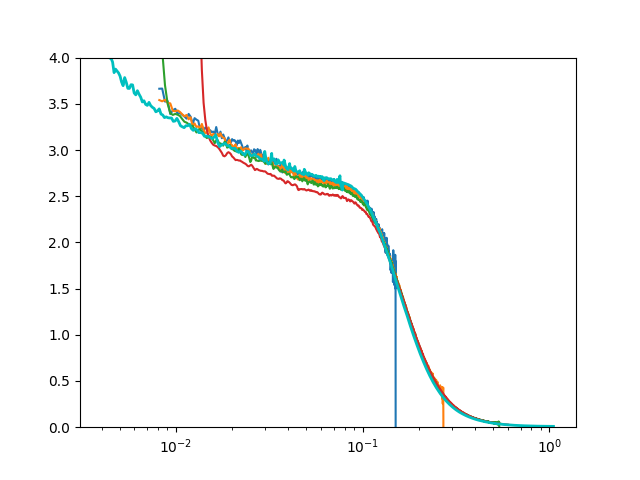

In [19]:
ResDir2 = r"C:\Users\AT280565\PycharmProjects\EdfToHdf5\data\GC_treated"
ref = np.loadtxt(os.path.join(ResDir2, 'GlassyCarbonT-10p_ErrorBar.dat'), skiprows=124)

plt.figure()
for index, (name, data) in enumerate(dict_rad_avg_I.items()):
    plt.plot(dict_rad_avg_Q[name], data)
plt.plot(ref[:, 0], ref[:, 1], linewidth=2, color='c')
plt.xscale("log")
plt.ylim(0, 4)
plt.show()